In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## **Reading File**

In [2]:
dataset=pd.read_csv('diabetes.csv', sep=',')
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [3]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# **Eploratory Data Analysis**

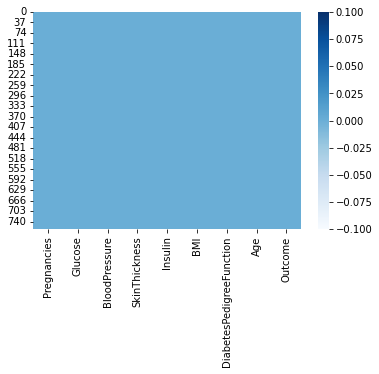

In [4]:
#missing values

sns.heatmap(dataset.isnull(), cmap='Blues')
plt.show()

<AxesSubplot:>

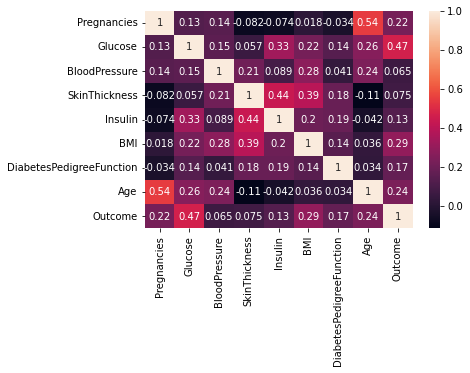

In [5]:
#correlation heatmap
sns.heatmap(dataset.corr(), annot=True)

<AxesSubplot:xlabel='Outcome', ylabel='Age'>

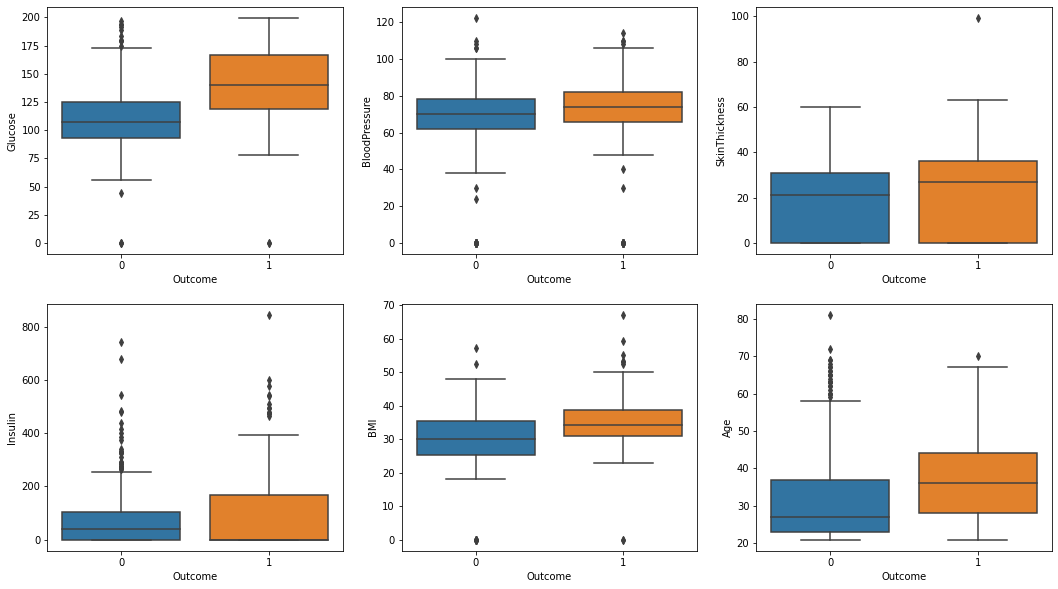

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.boxplot(ax=axes[0, 0], x='Outcome', y='Glucose', data=dataset)
sns.boxplot(ax=axes[0, 1], x='Outcome', y='BloodPressure', data=dataset)
sns.boxplot(ax=axes[0, 2], x='Outcome', y='SkinThickness', data=dataset)
sns.boxplot(ax=axes[1, 0], x='Outcome', y='Insulin', data=dataset)
sns.boxplot(ax=axes[1, 1], x='Outcome', y='BMI', data=dataset)
sns.boxplot(ax=axes[1, 2], x='Outcome', y='Age', data=dataset)

# **Information From EDA**
1. Patients with diabetes have higher glucose levels than those with no diabetes.
2. Patients with diabetes have slightly higher blood pressure than those with no diabetes.
3. Patients with diabetes have higher skin thickness than those with no diabetes.
4. Patients with diabetes have higher BMI than those with no diabetes.
5. Older people are more likely to develop diabets than young people.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb 

from sklearn.metrics import accuracy_score, roc_auc_score

In [8]:
# data splitting
X=dataset.drop(columns='Outcome')
y=dataset['Outcome']

In [9]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.19, stratify=y)

In [10]:
# no preprocessing
logit=LogisticRegression(max_iter=200, C=0.1)
logit.fit(X_train, y_train)

print(logit.score(X_train, y_train))
print(logit.score(X_test, y_test))
print(logit.coef_)

0.7636655948553055
0.8013698630136986
[[ 0.14221358  0.03251671 -0.01715511  0.00509334 -0.00181722  0.09172135
   0.35370949  0.01470235]]


In [11]:
scaler=MinMaxScaler()
scaled_train=scaler.fit_transform(X_train)
scaled_test=scaler.transform(X_test)

In [12]:
logit.fit(scaled_train, y_train)

print(logit.score(scaled_train, y_train))
print(logit.score(scaled_test, y_test))
print(logit.coef_)

0.6897106109324759
0.7328767123287672
[[ 0.69361023  1.39626085 -0.02936356  0.19059803  0.15291146  0.74064888
   0.43720423  0.6547426 ]]


# Using SVC

In [13]:
svc=SVC(kernel='linear')
svc.fit(scaled_train, y_train)

print('train accuracy: ',accuracy_score(y_train, svc.predict(scaled_train)))
print('test accuracy: ',accuracy_score(y_test, svc.predict(scaled_test)))

train accuracy:  0.7684887459807074
test accuracy:  0.8082191780821918


# Using xgboost

In [14]:
model=xgb.XGBClassifier()
model.fit(scaled_train, y_train)

print('train accuracy: ',accuracy_score(y_train, model.predict(scaled_train)))
print('test accuracy: ',accuracy_score(y_test, model.predict(scaled_test)))

train accuracy:  1.0
test accuracy:  0.7671232876712328


# Hyperparameter Tuning for XGBoost

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
param_grid = {
    'colsample_bytree': [0.2, 0.8, 0.6],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 4, 6, 8, 10]
}

grid_mse = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

In [17]:
grid_mse.fit(scaled_train, y_train)
print("Best parameters found: ", grid_mse.best_params_)
print("Best Accuracy found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found:  {'colsample_bytree': 0.8, 'max_depth': 2, 'n_estimators': 50}
Best Accuracy found:  0.8608622833924958


In [18]:
best_model=grid_mse.best_estimator_
print(accuracy_score(y_test, best_model.predict(scaled_test)))

0.8013698630136986


## Importing SVC File

In [19]:
import pickle

In [20]:
filename='diabetes_model.sav'
pickle.dump(svc, open(filename, 'wb'))